In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
savepng = False
savepgf = False

In [10]:
import os
import argparse
import pickle

import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from detection.vision.camproj import im2world_known_z, im2world_known_x
from detection.vision.utils import find_pole_bases, decode_depth, convert_semantic_color

In [11]:
class PoleDetector(object):
    """ 
    Class for pole-like objects detection from semantic segmentation images. 

    It takes advantage of the calibration matrices of the camera and projects 2D points in a image
    to the 3D world with known z coordinates. The bases of poles are used since they often stem from 
    the ground plane (z = 0). The obtained world coordinates are wrt the frame at the center of the front bumper.
    This relationship is embedded in the extrinsic parameters already.
    """

    def __init__(self, K, R, x0, pole_detect_params):
        """ 
        Constructor method. 

        Input:
            K: Numpy.array of 3x3 matrix for intrinsic calibration matrix.
            R: Numpy.array of 3x3 matrix for rotation matrix of the reference frame wrt the camera frame.
            x0: 3-by-1 Numpy.array representing camera's origin (principal point) wrt the front bumper's frame.
            pole_detect_params: Dict object storing pole detection algorithm parameters.
        """
        self.K = K
        self.R = R
        self.x0 = x0

        # For convenience of 2D-to-3D projection
        self.H = R.T @ np.linalg.inv(K)

        # u-v coordinates of pole bases in image
        self.pole_bases_uv = None
        # x-y coordinates of pole bases wrt the front bumper
        self.pole_bases_xy = None

        # For finding valid bounding boxes around pole-labelled pixels
        # Minimum bound box height (to ignore those too short)
        self._min_height = pole_detect_params['min_height']
        # Minimum bound box width (to ignore those too thin)
        self._min_width = pole_detect_params['min_width']
        # Maximum bound box width (to ignore those too wide)
        self._max_width = pole_detect_params['max_width']

    def update_poles(self, pole_image, upper_lim=None, z=0):
        """
        Update measurement of poles.

        It calls find_pole_bases() first to find pole bases in the passed-in image, then calls _get_pole_xy_fbumper() to get the x-y coordinates
        in the front bumper's frame.

        Input: 
            pole_image: OpenCV image with supported data type (e.g. np.uint8). The image should have non-zero values only
                        at pole pixels, which is easy to obtain from a semantic image.
            upper_lim:  Position of the upper_lim in the image (wrt the top of image). If not given, half point of image is used.
                        Note that larger upper_lim value means lower in image since it's the v coordinate.
            z: Assumed z coordinates perpendicular to ground of corresponding points
        Output:
            2-by-N Numpy.array containing x-y coordinates of pole bases wrt the front bumper.
        """
        self.find_pole_bases(pole_image, upper_lim)
        self._get_pole_xy_fbumper(z)
        return self.pole_bases_xy

    def get_pole_xyz_from_depth(self, depth_image, dist_cam_to_fbumper):
        """
        Derive the x-y coordinates wrt the front bumper of the currently-detected pole bases given the depth image.

        If no bases were found, it returns None.

        Input:
            depth_image: Numpy.array of depth image with np.float64 numbers representating depths of pixels.
                          It must have the same size as the pole_image used to detect the poles.
            dist_cam_to_fbumper: Longitudinal distance from the camera's principal point to the front bumper.
        Output:
            3-by-N Numpy.array containing x-y coordinates of pole bases wrt the front bumper. None if no bases were found.
        """
        if self.pole_bases_uv is None:
            return None
        
        x_world = depth_image[self.pole_bases_uv[1],
                              self.pole_bases_uv[0]] - dist_cam_to_fbumper
        # In front bumper's frame
        return im2world_known_x(self.H, self.x0, self.pole_bases_uv, x_world)

    def find_pole_bases(self, pole_image, upper_lim=None):
        """
        Find bases of poles in the given image.

        This method first finds connected pixels labelled as pole. Then the bottom center of their 
        bound boxes are extracted. Only image below the upper_lim is searched to avoid poles that are 
        too far. A pole taller than the camera is bound to cross the upper_lim, so this strategy can 
        find all near poles that are taller than the camera.

        Input: 
            pole_image: OpenCV image with supported data type (e.g. np.uint8). The image should have non-zero values only
                        at pole pixels, which is easy to obtained from a semantic image.
            upper_lim: Position of the upper_lim in the image (wrt the top of image). If not given, half point of image is used.
        Output:
            pole_bases_uv: Image coordiantes (u-v) of detected pole bases.
        """
        self.pole_bases_uv = find_pole_bases(
            pole_image, self._min_width, self._max_width, self._min_height, use_bbox_center=False, upper_lim=upper_lim)
        return self.pole_bases_uv

    def _get_pole_xy_fbumper(self, z=0):
        """
        Get x-y coordinates of poles in the front bumper's frame.

        This method assumes the poles stem from the ground plane (z = 0), then project
        the pole bases in the image to the 3D world. The obtained world coordinates are
        wrt the frame at the center of the front bumper.

        If no u-v coordinates of pole bases extracted, set pole_bases_xy to None.

        Input:
            z: Assumed z coordinates perpendicular to ground of corresponding points
        """
        if self.pole_bases_uv is not None:
            pole_bases_xyz = im2world_known_z(
                self.H, self.x0, self.pole_bases_uv, z_world=z)
            self.pole_bases_xy = pole_bases_xyz[0:2, :]
        else:
            self.pole_bases_xy = None


In [12]:
def single(folder_name, image_idx):
    argparser = argparse.ArgumentParser(
        description='Pole Detection using Semantic Images')
    argparser.add_argument('config', type=argparse.FileType(
        'r'), help='yaml file for carla configuration')
    argparser.add_argument('vision_params', type=argparse.FileType(
        'r'), help='yaml file for vision algorithm parameters')
    args = argparser.parse_args(args=['../settings/carlasim.yaml', '../settings/vision.yaml'])

    # Read configurations from yaml file
    with args.config as config_file:
        carla_config = yaml.safe_load(config_file)
    with args.vision_params as vision_params_file:
        vision_params = yaml.safe_load(vision_params_file)

    dist_cam_to_fbumper = (carla_config['ego_veh']['raxle_to_fbumper']
                           - carla_config['sensor']['front_camera']['pos_x']
                           - carla_config['ego_veh']['raxle_to_cg'])

    # Load camera parameters
    with open('../calib_data.pkl', 'rb') as f:
        calib_data = pickle.load(f)
    K = calib_data['K']
    R = calib_data['R']
    x0 = calib_data['x0']

    # Load data
    path_to_folder = os.path.join('../recordings', folder_name)
    with open(os.path.join(path_to_folder, 'sensor_data.pkl'), 'rb') as f:
        sensor_data = pickle.load(f)

    ss_images = sensor_data['semantic_camera']['ss_image']
    depth_buffers = sensor_data['depth_camera']['depth_buffer']

    # Extract pole-relevant semantic labels
    ss_image = ss_images[image_idx]
    ss_image_copy = convert_semantic_color(ss_image.copy())
    pole_image = (ss_image == 5).astype(np.uint8)

    ################ Save of pole images ################
    plt.imshow(ss_image_copy)
    plt.plot([0, 799], [305, 305], 'orange')
    plt.axis('off')
    if savepng:
        plt.savefig('images/pole/pole_image.png', dpi=300)
    plt.show(block=False)

    plt.imshow(pole_image[305:, :])
    plt.axis('off')
    if savepng:
        plt.savefig('images/pole/pole_base.png', dpi=300)
    plt.show(block=False)

    depth_buffer = depth_buffers[image_idx]
    depth_image = decode_depth(depth_buffer)

    pole_detector = PoleDetector(K, R, x0, vision_params['pole'])
    pole_detector.update_poles(pole_image, upper_lim=305, z=0)
    poles_xy_z0 = pole_detector.pole_bases_xy
    pole_detector.update_poles(pole_image, upper_lim=305, z=0.1)
    poles_xy_z1 = pole_detector.pole_bases_xy

    pole_bases_uv = pole_detector.pole_bases_uv

    _, ax = plt.subplots(1, 2)
    fig_result, ax_result = plt.subplots(1, 1)

    if pole_bases_uv is not None:
        x_world = depth_image[pole_bases_uv[1],
                              pole_bases_uv[0]] - dist_cam_to_fbumper
        poles_gt_xyz = im2world_known_x(
            pole_detector.H, pole_detector.x0, pole_detector.pole_bases_uv, x_world)

        # Visualization
        for base_coord in pole_detector.pole_bases_uv.T:
            ss_image_copy = cv2.circle(
                ss_image_copy, (base_coord[0], base_coord[1]), 10, color=[1, 0, 0], thickness=5)

        ax[0].imshow(ss_image_copy)
        # ax[1].axis('equal')
        ax[1].plot(poles_xy_z0[1, :], poles_xy_z0[0, :], '.', label='z = 0')
        ax[1].plot(poles_xy_z1[1, :], poles_xy_z1[0, :], '.', label='z = 1')
        ax[1].plot(poles_gt_xyz[1, :], poles_gt_xyz[0, :], '.', label='GT')
        ax[1].set_xlim((30, -30))
        ax[1].set_ylim((-5, 60))

        ax_result.plot(poles_xy_z0[1, :], poles_xy_z0[0, :], '.', label='height = 0')
        ax_result.plot(poles_xy_z1[1, :], poles_xy_z1[0, :], '.', label='height = 0.1')
        ax_result.plot(poles_gt_xyz[1, :], poles_gt_xyz[0, :], '.', label='accurate')
        ax_result.invert_xaxis()
        ax_result.set_xlim((20, -20))
        ax_result.set_ylim((0, 40))
        ax_result.set_aspect('equal')
        ax_result.set_xlabel(r'$y_\text{s}$ [m]')
        ax_result.set_ylabel(r'$x_\text{s}$ [m]')
        ax_result.grid('on')
        ax_result.legend()
        if savepgf:
            fig_result.savefig('images/pole/pole_result.pgf', dpi=300)

        
    ax[0].imshow(ss_image_copy)
    plt.legend()
    plt.show()

In [13]:
if savepgf:
    import matplotlib
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
        'pgf.preamble': [r'\usepackage{siunitx} \usepackage{amsmath}']
    })
else:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    params = {'text.latex.preamble' : r'\usepackage{siunitx} \usepackage{amsmath}'}
    plt.rcParams.update(params)

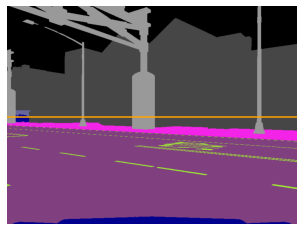

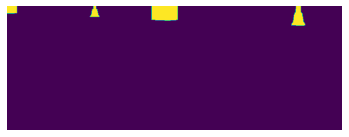

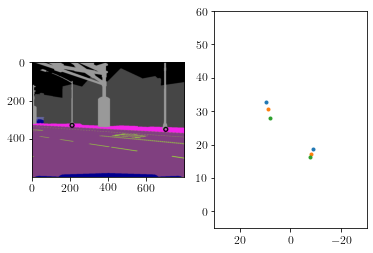

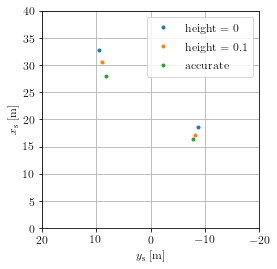

In [14]:
single('urban', 750)